In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn
import tensorflow as tf
import glob

Data Pipeline

In [3]:
filepaths = glob.glob('datasets\Tumor\yes\*.jpg') + glob.glob('datasets\Tumor\yes\*.JPG') +glob.glob('datasets\Tumor\yes\*.png')
filepaths_negative =   glob.glob('datasets\\Tumor\\no\\*.jpg') + glob.glob('datasets\\Tumor\\no\\*.jpeg')

In [4]:
def preprocess_to_tensors(file_path):
    try:
        img = tf.io.read_file(file_path)
        img = tf.image.decode_image(img, channels=3)
        img = tf.cast(img, tf.float32) / 255.0
        img.set_shape([None, None, 3])
        img = tf.image.resize(img , [218, 180])
        return img
    except tf.errors.InvalidArgumentError:
        # Skip files that are not in a supported format
        return None

In [5]:
def preprocess_to_tensors_no(file_path):
    img = tf.io.read_file(tf.cast(file_path, tf.string))
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.cast(img, tf.float32) / 255.0
    img = tf.image.resize_with_pad(img, 218, 180)
    return img

In [6]:
imgtensorarray = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)

In [7]:
dataset = tf.data.Dataset.from_tensor_slices(filepaths)
dataset = dataset.map(preprocess_to_tensors)
for img in dataset:
    imgtensorarray = imgtensorarray.write(imgtensorarray.size(), img)

train_yes = imgtensorarray.stack()

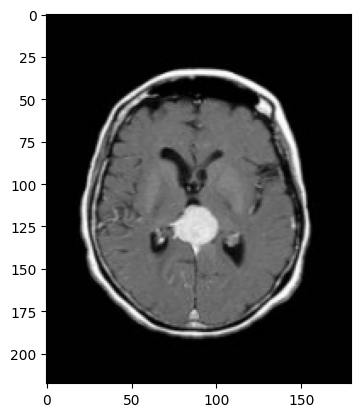

In [8]:
plt.figure()
plt.imshow(train_yes[16])

In [9]:
train_yes.shape

TensorShape([309, 218, 180, 3])

In [10]:
dataset_negative = tf.data.Dataset.from_tensor_slices(filepaths_negative)
dataset_negative = dataset_negative.map(preprocess_to_tensors_no)

In [11]:
img_negative_tensorarray = tf.TensorArray(tf.float32, size = 0 , dynamic_size=True)
for neg_img in dataset_negative:
    img_negative_tensorarray = img_negative_tensorarray.write(img_negative_tensorarray.size(), neg_img)


train_no = img_negative_tensorarray.stack()

In [12]:
train_no.shape

TensorShape([97, 218, 180, 3])

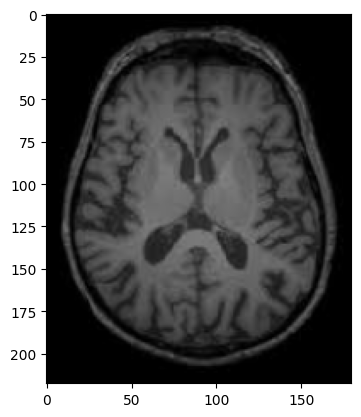

In [13]:
plt.imshow(train_no[0])

### Utility Functions:

In [14]:
from pathlib import Path
from time import strftime

def get_run_logdir(root_logdir='my_logs'):
  return Path(root_logdir)/strftime('rin_%Y_%m_%d_%H_%M_%S')

run_logdir = get_run_logdir()